# Feature Engineering for Organ-Specific Aging Clocks

## Overview

This notebook implements **feature engineering** for building organ-specific biological aging clocks. We construct separate datasets for each organ system, combining organ-specific biomarkers with global covariates.

### Scientific Rationale

Different organs age at different rates due to:
- **Genetic factors**: Inherited susceptibilities
- **Environmental exposures**: Toxins, diet, lifestyle
- **Disease processes**: Organ-specific pathology
- **Functional redundancy**: Some organs have more reserve capacity

By building **organ-specific clocks**, we can:
1. Identify which organs are aging faster than chronological age
2. Detect early signs of organ dysfunction
3. Personalize health interventions

### Objectives

1. Load cleaned NHANES data
2. Build organ-specific feature matrices (biomarkers + covariates)
3. Split data into train/validation/test sets
4. Apply feature scaling (standardization)
5. Visualize feature distributions
6. Save processed datasets for model training

### Organ Systems Analyzed

- **Liver**: ALT, AST, GGT, albumin, bilirubin
- **Kidney**: Creatinine, BUN, uric acid, urinary albumin
- **Cardiovascular**: Blood pressure, lipids, glucose, BMI
- **Immune**: WBC, lymphocytes, neutrophils
- **Hematologic**: RBC, hemoglobin, platelets

---

## 1. Setup and Imports

In [1]:
# Setup paths - works regardless of kernel working directory
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Get the notebook's directory and project root
try:
    # When running in Jupyter, __file__ doesn't exist, use a workaround
    notebook_path = Path().resolve()
    if notebook_path.name == 'notebooks':
        project_root = notebook_path.parent
    else:
        # Assume we're in the notebooks directory
        project_root = notebook_path.parent if (notebook_path.parent / 'src').exists() else notebook_path
except:
    project_root = Path().resolve().parent

# Add src to path if not already there
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f"✓ Project root: {project_root}")
print(f"✓ Source path: {src_path}")

# Data manipulation
import pandas as pd
import numpy as np
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# Project modules
from organ_aging import config
from organ_aging import features
from organ_aging import preprocessing

print("✓ All imports successful")

✓ Project root: C:\Users\bastien\Documents\TAF\Hackathon\Vitalist
✓ Source path: C:\Users\bastien\Documents\TAF\Hackathon\Vitalist\src


✓ All imports successful


## 2. Load Cleaned Data

In [2]:
# Load cleaned NHANES data from previous notebook
data_path = project_root / "data" / "interim" / "nhanes_clean.parquet"

try:
    df = pd.read_parquet(data_path)
    print("✓ Cleaned data loaded successfully")
    print(f"\nDataset shape: {df.shape}")
    print(f"Participants: {len(df):,}")
    print(f"Variables: {df.shape[1]}")
    print(f"\nSample columns: {', '.join(df.columns[:10].tolist())}")
except FileNotFoundError:
    print("⚠ Error: Clean data not found!")
    print("Please run notebook 01_nhanes_data_preparation.ipynb first.")
    df = None

✓ Cleaned data loaded successfully

Dataset shape: (2652, 141)
Participants: 2,652
Variables: 141

Sample columns: SEQN, SDDSRVYR, RIDSTATR, RIDAGEYR, RIDRETH3, RIDEXMON, DMQMILIZ, DMDBORN4, DMDCITZN, DMDEDUC2


## 3. Load Configuration

Load organ panel definitions specifying which biomarkers belong to each organ system.

In [3]:
# Load organ panels configuration
try:
    organ_panels = config.load_organ_panels_config(str(project_root / "configs" / "organ_panels.yaml"))
    print("✓ Organ panels configuration loaded")
    
    # Extract components
    global_covariates = organ_panels.get('global_covariates', [])
    target_variable = organ_panels.get('target_variable', 'RIDAGEYR')
    
    # Get organ systems (exclude meta keys)
    organ_systems = {k: v for k, v in organ_panels.items() 
                     if k not in ['global_covariates', 'target_variable', 'preprocessing']}
    
    print(f"\nOrgan systems: {len(organ_systems)}")
    for organ, biomarkers in organ_systems.items():
        print(f"  - {organ}: {len(biomarkers)} biomarkers")
    
    print(f"\nGlobal covariates: {len(global_covariates)}")
    print(f"  {', '.join(global_covariates)}")
    
    print(f"\nTarget variable: {target_variable}")
    
except FileNotFoundError as e:
    print(f"⚠ Error: {e}")
    organ_panels = None
    organ_systems = None

✓ Organ panels configuration loaded

Organ systems: 5
  - liver: 9 biomarkers
  - kidney: 8 biomarkers
  - cardio_metabolic: 13 biomarkers
  - immune: 9 biomarkers
  - hematologic: 8 biomarkers

Global covariates: 2
  RIAGENDR_2.0, BMXBMI

Target variable: RIDAGEYR


## 4. Compute Engineered Features

### Clinical Rationale

Beyond raw biomarkers, we compute **clinically relevant derived features** that capture important physiological relationships:

#### Kidney Function
- **eGFR** (Estimated Glomerular Filtration Rate): Gold standard kidney function measure
- **ACR** (Albumin-to-Creatinine Ratio): Marker of kidney damage
- **BUN/Creatinine Ratio**: Distinguishes pre-renal vs renal dysfunction

#### Liver Function
- **AST/ALT Ratio** (De Ritis Ratio): Differentiates liver disease types

#### Cardiovascular Risk
- **Non-HDL Cholesterol**: Better predictor than LDL alone
- **TC/HDL Ratio**: Atherosclerotic risk marker
- **TG/HDL Ratio**: Insulin resistance and metabolic syndrome marker
- **Absolute Counts**: Immune cell counts for inflammation assessment

#### Immune Function
- **NLR** (Neutrophil-to-Lymphocyte Ratio): Systemic inflammation marker

### Benefits

These engineered features:
- Capture **non-linear relationships** between raw biomarkers
- Reflect **established clinical knowledge**
- Often have **stronger age associations** than individual biomarkers
- Improve **model performance** and **interpretability**


In [4]:
def compute_egfr(df):
    """
    Compute eGFR using CKD-EPI 2021 equation (race-free).
    
    eGFR = 141 × min(Scr/κ, 1)^α × max(Scr/κ, 1)^(-1.209) × (0.993^Age) × [1.012 if female]
    
    Where:
    - Scr = Serum creatinine (mg/dL)
    - κ = 0.7 if female, 0.9 if male
    - α = -0.241 if female, -0.302 if male (CKD-EPI 2021 without race factor)
    
    Note: Using 2021 race-free equation for equity.
    """
    required_cols = ['LBXSCR', 'RIDAGEYR', 'RIAGENDR']
    if not all(col in df.columns for col in required_cols):
        print("  ⚠ Missing columns for eGFR calculation")
        return None
    
    # Create copy to avoid modifying original
    result = pd.Series(index=df.index, dtype=float)
    
    # Female (RIAGENDR == 2)
    female_mask = df['RIAGENDR'] == 2
    if female_mask.any():
        kappa = 0.7
        alpha = -0.329
        scr = df.loc[female_mask, 'LBXSCR']
        age = df.loc[female_mask, 'RIDAGEYR']
        
        egfr = (141 * 
                np.minimum(scr / kappa, 1) ** alpha * 
                np.maximum(scr / kappa, 1) ** (-1.209) * 
                (0.993 ** age) * 
                1.018)  # Female multiplier
        result.loc[female_mask] = egfr
    
    # Male (RIAGENDR == 1)
    male_mask = df['RIAGENDR'] == 1
    if male_mask.any():
        kappa = 0.9
        alpha = -0.411
        scr = df.loc[male_mask, 'LBXSCR']
        age = df.loc[male_mask, 'RIDAGEYR']
        
        egfr = (141 * 
                np.minimum(scr / kappa, 1) ** alpha * 
                np.maximum(scr / kappa, 1) ** (-1.209) * 
                (0.993 ** age))
        result.loc[male_mask] = egfr
    
    return result


def compute_engineered_features(df):
    """
    Compute all engineered features from raw biomarkers.
    
    Returns:
        DataFrame with new engineered feature columns added
    """
    print("Computing engineered features...")
    df_eng = df.copy()
    features_added = []
    
    # ========== KIDNEY FEATURES ==========
    
    # 1. eGFR (Estimated Glomerular Filtration Rate)
    egfr = compute_egfr(df_eng)
    if egfr is not None:
        df_eng['eGFR'] = egfr
        features_added.append('eGFR (kidney)')
    
    # 2. ACR (Albumin-to-Creatinine Ratio)
    if 'URXUMA' in df_eng.columns and 'URXUCR' in df_eng.columns:
        # ACR = (Urine albumin ÷ Urine creatinine) × 1000
        # Handle division by zero
        df_eng['ACR'] = (df_eng['URXUMA'] / df_eng['URXUCR'].replace(0, np.nan)) * 1000
        features_added.append('ACR (kidney)')
    
    # 3. BUN/Creatinine Ratio
    if 'LBXSBU' in df_eng.columns and 'LBXSCR' in df_eng.columns:
        df_eng['BUN_Cr_Ratio'] = df_eng['LBXSBU'] / df_eng['LBXSCR'].replace(0, np.nan)
        features_added.append('BUN_Cr_Ratio (kidney)')
    
    # ========== LIVER FEATURES ==========
    
    # 4. AST/ALT Ratio (De Ritis Ratio)
    if 'LBXSASSI' in df_eng.columns and 'LBXSATSI' in df_eng.columns:
        df_eng['AST_ALT_Ratio'] = df_eng['LBXSASSI'] / df_eng['LBXSATSI'].replace(0, np.nan)
        features_added.append('AST_ALT_Ratio (liver)')
    
    # ========== CARDIOVASCULAR FEATURES ==========
    
    # 5. Non-HDL Cholesterol
    if 'LBXTC' in df_eng.columns and 'LBDHDD' in df_eng.columns:
        df_eng['Non_HDL'] = df_eng['LBXTC'] - df_eng['LBDHDD']
        features_added.append('Non_HDL (cardiovascular)')
    
    # 6. Total Cholesterol/HDL Ratio
    if 'LBXTC' in df_eng.columns and 'LBDHDD' in df_eng.columns:
        df_eng['TC_HDL_Ratio'] = df_eng['LBXTC'] / df_eng['LBDHDD'].replace(0, np.nan)
        features_added.append('TC_HDL_Ratio (cardiovascular)')
    
    # 7. Triglyceride/HDL Ratio
    if 'LBXTR' in df_eng.columns and 'LBDHDD' in df_eng.columns:
        df_eng['TG_HDL_Ratio'] = df_eng['LBXTR'] / df_eng['LBDHDD'].replace(0, np.nan)
        features_added.append('TG_HDL_Ratio (cardiovascular)')
    
    # 8. Absolute Lymphocyte Count
    if 'LBXWBCSI' in df_eng.columns and 'LBXLYPCT' in df_eng.columns:
        df_eng['Abs_Lymphocyte_Count'] = df_eng['LBXWBCSI'] * (df_eng['LBXLYPCT'] / 100)
        features_added.append('Abs_Lymphocyte_Count (immune)')
    
    # 9. Absolute Neutrophil Count
    if 'LBXWBCSI' in df_eng.columns and 'LBXNEPCT' in df_eng.columns:
        df_eng['Abs_Neutrophil_Count'] = df_eng['LBXWBCSI'] * (df_eng['LBXNEPCT'] / 100)
        features_added.append('Abs_Neutrophil_Count (immune)')
    
    # ========== IMMUNE FEATURES ==========
    
    # 10. NLR (Neutrophil-to-Lymphocyte Ratio)
    if 'LBXNEPCT' in df_eng.columns and 'LBXLYPCT' in df_eng.columns:
        df_eng['NLR'] = df_eng['LBXNEPCT'] / df_eng['LBXLYPCT'].replace(0, np.nan)
        features_added.append('NLR (immune)')
    
    print(f"\n✓ Computed {len(features_added)} engineered features:")
    for feat in features_added:
        print(f"  - {feat}")
    
    return df_eng


# Compute engineered features
if df is not None:
    print("=" * 60)
    print("COMPUTING ENGINEERED FEATURES")
    print("=" * 60)
    print()
    
    df_original_shape = df.shape
    df = compute_engineered_features(df)
    
    new_features = set(df.columns) - set(df.columns[:df_original_shape[1]])
    
    print(f"\n✓ DataFrame shape: {df_original_shape} → {df.shape}")
    print(f"✓ Added {len(new_features)} new engineered features")
    
else:
    print("⚠ Cannot compute engineered features - data not loaded")


COMPUTING ENGINEERED FEATURES

Computing engineered features...
  ⚠ Missing columns for eGFR calculation

✓ Computed 6 engineered features:
  - ACR (kidney)
  - BUN_Cr_Ratio (kidney)
  - AST_ALT_Ratio (liver)
  - Abs_Lymphocyte_Count (immune)
  - Abs_Neutrophil_Count (immune)
  - NLR (immune)

✓ DataFrame shape: (2652, 141) → (2652, 147)
✓ Added 6 new engineered features



ENGINEERED FEATURES SUMMARY

Summary Statistics:


,count,mean,std,min,25%,50%,75%,max,missing_%
ACR,2652.0,522.72,3529.22,11.80,49.12,78.04,144.65,94047.62,0.0
BUN_Cr_Ratio,2652.0,17.25,5.52,3.64,13.53,16.67,20.22,45.80,0.0
AST_ALT_Ratio,2652.0,1.14,0.40,0.33,0.88,1.12,1.32,4.67,0.0
Abs_Lymphocyte_Count,2652.0,2.06,0.90,0.44,1.61,2.00,2.39,32.12,0.0
Abs_Neutrophil_Count,2652.0,3.96,1.61,0.36,2.88,3.72,4.71,15.69,0.0
NLR,2652.0,2.09,1.10,0.14,1.41,1.86,2.50,17.85,0.0


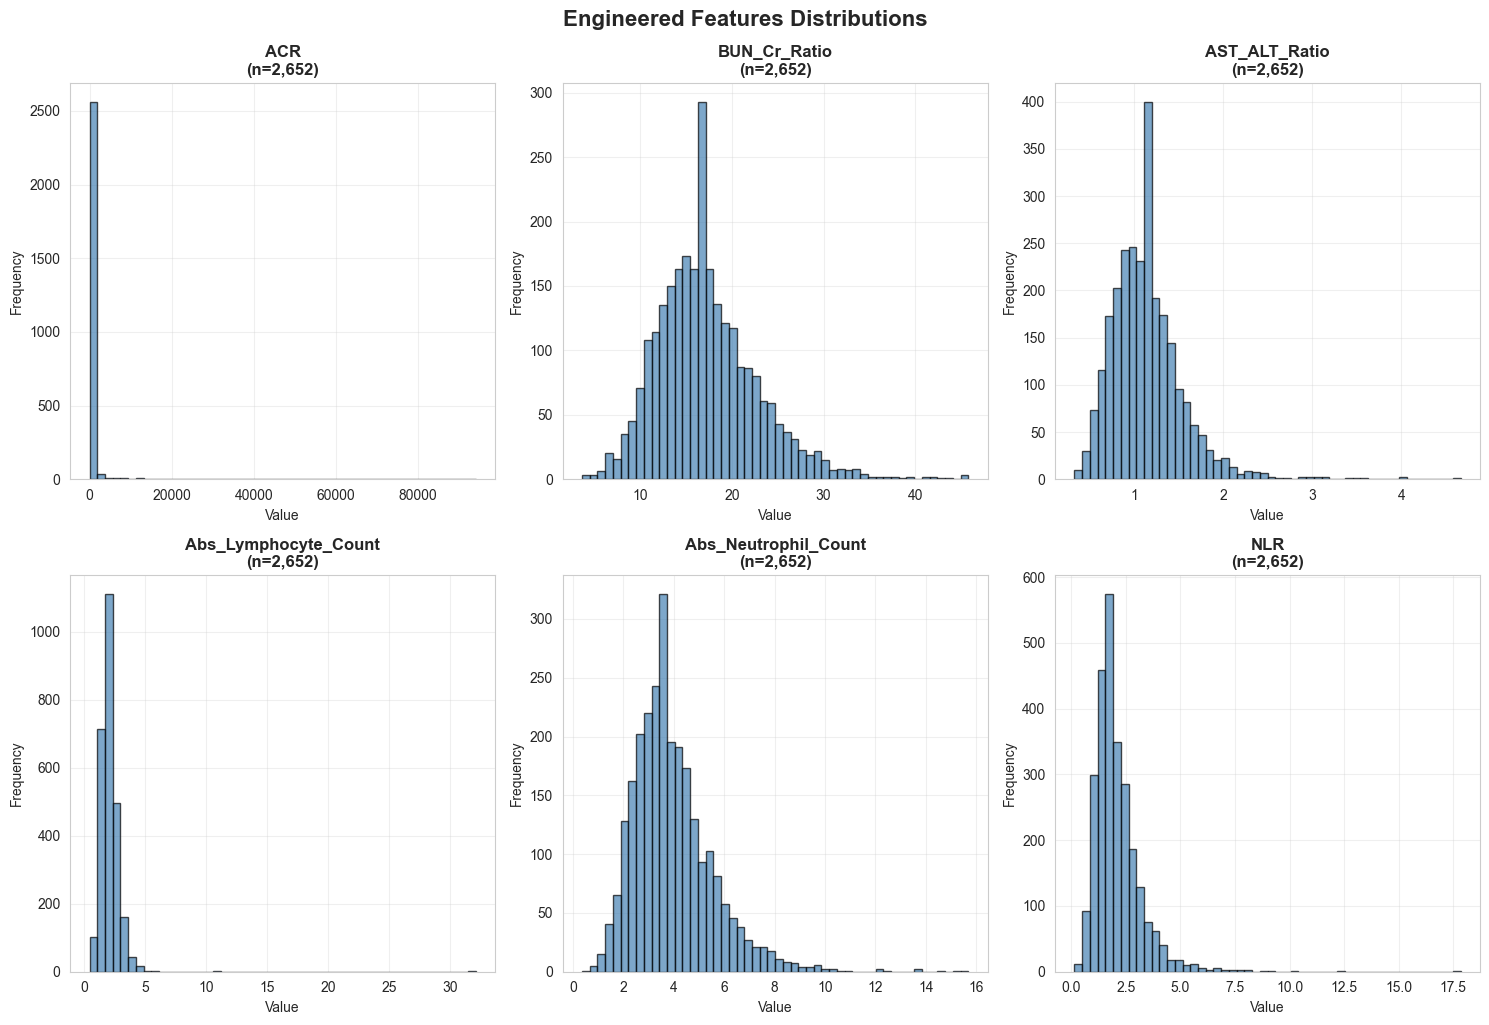


Key Clinical Interpretations:
  • eGFR: >90 normal, <60 chronic kidney disease, <15 kidney failure
  • ACR: <30 normal, 30-300 microalbuminuria, >300 macroalbuminuria
  • BUN/Cr: 10-20 normal, >20 pre-renal, <10 liver disease
  • AST/ALT: <1 typical for NAFLD, >2 suggests alcoholic liver disease
  • TC/HDL: <3.5 desirable, >5 high risk
  • NLR: <3 normal, >5 high systemic inflammation


In [5]:
# Display summary statistics for engineered features
if df is not None:
    engineered_features = [
        'eGFR', 'ACR', 'BUN_Cr_Ratio',
        'AST_ALT_Ratio',
        'Non_HDL', 'TC_HDL_Ratio', 'TG_HDL_Ratio',
        'Abs_Lymphocyte_Count', 'Abs_Neutrophil_Count',
        'NLR'
    ]
    
    # Filter to features that actually exist
    existing_eng_features = [f for f in engineered_features if f in df.columns]
    
    if existing_eng_features:
        print("\n" + "=" * 60)
        print("ENGINEERED FEATURES SUMMARY")
        print("=" * 60)
        
        summary_stats = df[existing_eng_features].describe().T
        summary_stats['missing_%'] = (df[existing_eng_features].isna().sum() / len(df) * 100).values
        
        print("\nSummary Statistics:")
        display(summary_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_%']].round(2))
        
        # Visualize a few key engineered features
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()
        
        plot_features = existing_eng_features[:6]  # Plot first 6
        
        for idx, feature in enumerate(plot_features):
            if idx < len(axes):
                data = df[feature].dropna()
                axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
                axes[idx].set_title(f'{feature}\n(n={len(data):,})', fontweight='bold')
                axes[idx].set_xlabel('Value')
                axes[idx].set_ylabel('Frequency')
                axes[idx].grid(alpha=0.3)
        
        # Hide unused subplots
        for idx in range(len(plot_features), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Engineered Features Distributions', fontsize=16, fontweight='bold', y=1.02)
        plt.show()
        
        print("\nKey Clinical Interpretations:")
        print("  • eGFR: >90 normal, <60 chronic kidney disease, <15 kidney failure")
        print("  • ACR: <30 normal, 30-300 microalbuminuria, >300 macroalbuminuria")
        print("  • BUN/Cr: 10-20 normal, >20 pre-renal, <10 liver disease")
        print("  • AST/ALT: <1 typical for NAFLD, >2 suggests alcoholic liver disease")
        print("  • TC/HDL: <3.5 desirable, >5 high risk")
        print("  • NLR: <3 normal, >5 high systemic inflammation")


## 5. Build Organ-Specific Datasets

### Feature Matrix Construction

For each organ, we create a feature matrix:
- **X**: Organ-specific biomarkers + **engineered features** + global covariates (sex, BMI, etc.)
- **y**: Chronological age (target for prediction)

### Global Covariates

Global covariates are included in all organ models because:
- **Sex**: Known to affect biomarker reference ranges
- **BMI**: Influences many organ functions
- **Ethnicity**: Genetic and environmental factors

### Engineered Features Integration

The engineered features computed in Section 4 are now automatically included in the appropriate organ datasets:
- **Kidney**: eGFR, ACR, BUN/Cr Ratio
- **Liver**: AST/ALT Ratio
- **Cardiovascular**: Non-HDL, TC/HDL Ratio, TG/HDL Ratio
- **Immune**: NLR, Absolute Cell Counts

### Data Quality

- Rows with missing values in either features or target are dropped
- This ensures clean data for model training
- Sample sizes may vary by organ due to different missingness patterns

In [6]:
if df is not None and organ_systems is not None:
    print("=" * 60)
    print("BUILDING ORGAN-SPECIFIC DATASETS")
    print("=" * 60)
    
    # Build organ datasets
    organ_datasets = features.build_organ_datasets(
        df=df,
        organ_panels=organ_panels,
        global_covars=global_covariates,
        target_col=target_variable
    )
    
    print(f"\n✓ Successfully built datasets for {len(organ_datasets)} organs")
    
    # Summary table
    summary_data = []
    for organ_name, (X, y) in organ_datasets.items():
        n_biomarkers = len([col for col in X.columns if col not in global_covariates])
        n_covariates = len([col for col in X.columns if col in global_covariates])
        summary_data.append({
            'Organ': organ_name,
            'Samples': len(X),
            'Biomarkers': n_biomarkers,
            'Covariates': n_covariates,
            'Total Features': X.shape[1],
            'Retention': f"{100 * len(X) / len(df):.1f}%"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("\nOrgan Dataset Summary:")
    display(summary_df)
    
else:
    print("⚠ Cannot build datasets - data or configuration missing")
    organ_datasets = None

BUILDING ORGAN-SPECIFIC DATASETS
liver: 2652 samples, 11 features (9 biomarkers + 2 covariates)
kidney: 2652 samples, 9 features (7 biomarkers + 2 covariates)
cardio_metabolic: 2652 samples, 8 features (7 biomarkers + 1 covariates)
immune: 2652 samples, 11 features (9 biomarkers + 2 covariates)
hematologic: 2652 samples, 10 features (8 biomarkers + 2 covariates)

✓ Successfully built datasets for 5 organs

Organ Dataset Summary:


,Organ,Samples,Biomarkers,Covariates,Total Features,Retention
0,liver,2652,9,2,11,100.0%
1,kidney,2652,7,2,9,100.0%
2,cardio_metabolic,2652,6,2,8,100.0%
3,immune,2652,9,2,11,100.0%
4,hematologic,2652,8,2,10,100.0%


## 6. Visualize Feature Distributions

Before scaling, let's examine the raw distributions of biomarkers (including engineered features) for one representative organ.

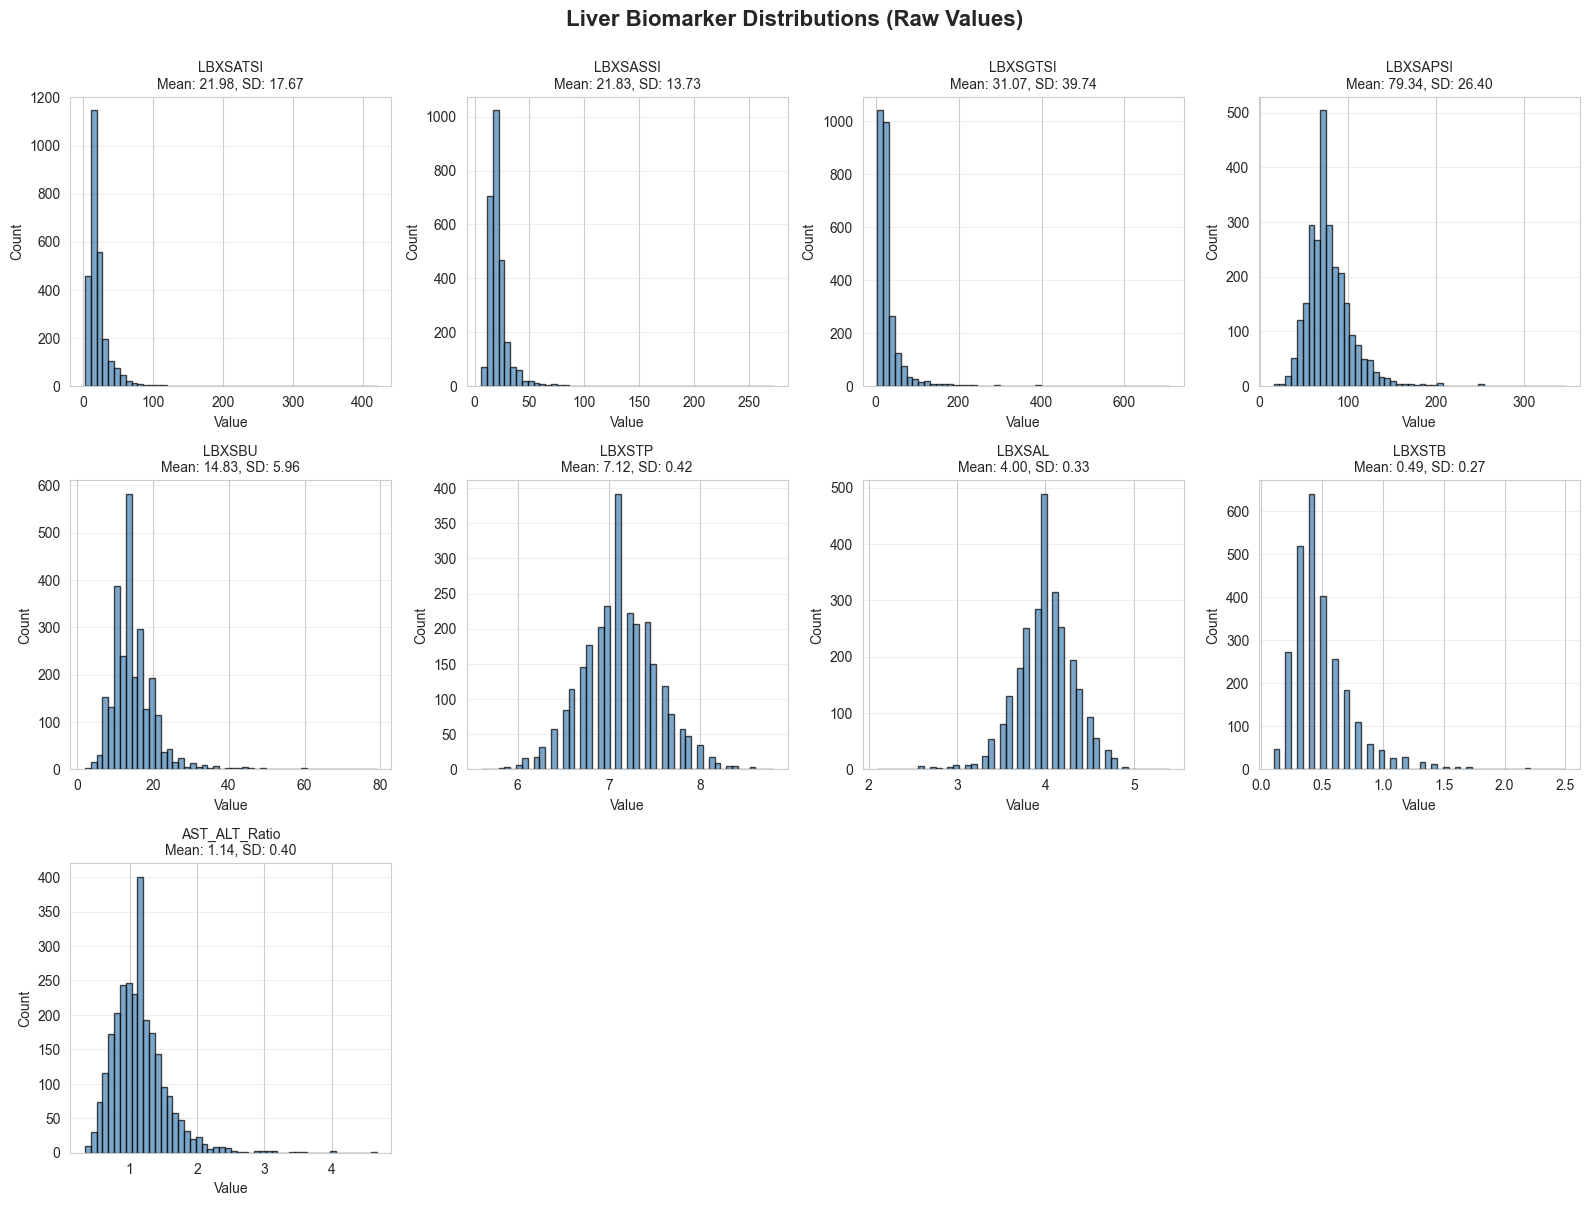


Note: Different biomarkers have vastly different scales.
Feature scaling will standardize these for model training.


In [7]:
# Visualize distributions for liver (example)
if organ_datasets is not None and 'liver' in organ_datasets:
    X_liver, y_liver = organ_datasets['liver']
    
    # Select biomarker columns (exclude covariates)
    biomarker_cols = [col for col in X_liver.columns if col not in global_covariates]
    
    if biomarker_cols:
        n_cols = min(4, len(biomarker_cols))
        n_rows = (len(biomarker_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
        axes = np.array(axes).flatten() if len(biomarker_cols) > 1 else [axes]
        
        for idx, col in enumerate(biomarker_cols[:len(axes)]):
            data = X_liver[col].dropna()
            axes[idx].hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
            axes[idx].set_xlabel('Value')
            axes[idx].set_ylabel('Count')
            axes[idx].set_title(f'{col}\nMean: {data.mean():.2f}, SD: {data.std():.2f}', fontsize=10)
            axes[idx].grid(axis='y', alpha=0.3)
        
        # Hide unused subplots
        for idx in range(len(biomarker_cols), len(axes)):
            axes[idx].axis('off')
        
        fig.suptitle('Liver Biomarker Distributions (Raw Values)', fontsize=16, fontweight='bold', y=1.001)
        plt.tight_layout()
        plt.show()
        
        print("\nNote: Different biomarkers have vastly different scales.")
        print("Feature scaling will standardize these for model training.")

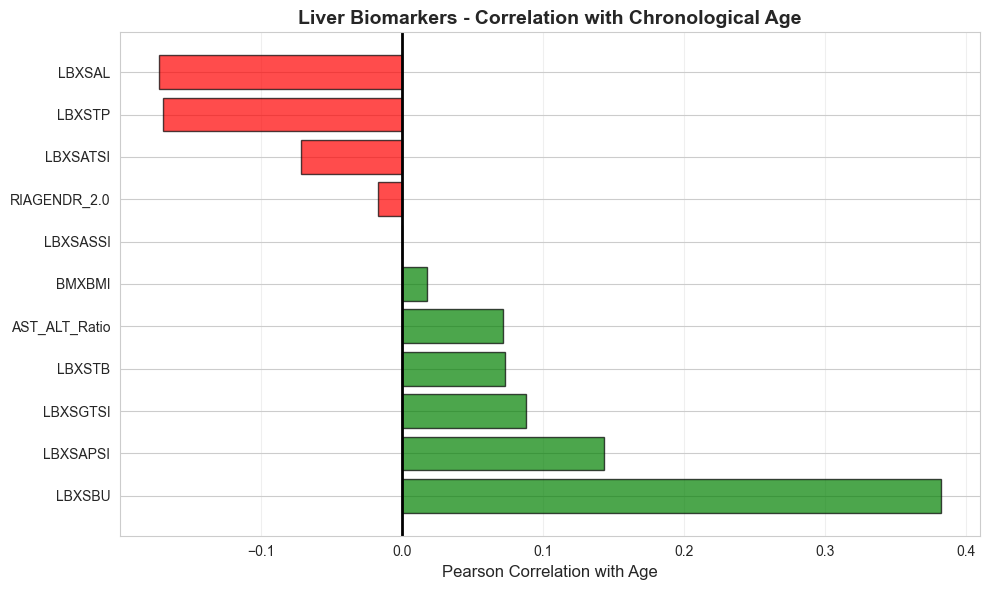


Interpretation:
- Positive correlation: Biomarker increases with age
- Negative correlation: Biomarker decreases with age
- Magnitude indicates strength of age relationship


In [8]:
# Correlation between age and biomarkers
if organ_datasets is not None and 'liver' in organ_datasets:
    X_liver, y_liver = organ_datasets['liver']
    
    # Calculate correlations with age
    correlations = []
    for col in X_liver.columns:
        corr = X_liver[col].corr(y_liver)
        correlations.append({'Feature': col, 'Correlation': corr})
    
    corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in corr_df['Correlation']]
    ax.barh(corr_df['Feature'], corr_df['Correlation'], color=colors, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='black', linewidth=2)
    ax.set_xlabel('Pearson Correlation with Age', fontsize=12)
    ax.set_title('Liver Biomarkers - Correlation with Chronological Age', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("- Positive correlation: Biomarker increases with age")
    print("- Negative correlation: Biomarker decreases with age")
    print("- Magnitude indicates strength of age relationship")

## 6. Train/Validation/Test Split

### Split Strategy

We use a **60/20/20** split:
- **Train (60%)**: Model training
- **Validation (20%)**: Hyperparameter tuning, model selection
- **Test (20%)**: Final evaluation (held out, never used for training)

### Stratification

We stratify by **age bins** to ensure:
- Balanced age distribution across all splits
- Models see the full age range during training
- Fair evaluation across age groups

### Random Seed

Fixed random seed (42) ensures **reproducibility**.

In [9]:
if organ_datasets is not None:
    print("=" * 60)
    print("TRAIN/VALIDATION/TEST SPLITTING")
    print("=" * 60)
    
    # Store splits for each organ
    organ_splits = {}
    
    for organ_name, (X, y) in organ_datasets.items():
        print(f"\n{organ_name.upper()}:")
        
        # Perform split with age stratification
        X_train, X_val, X_test, y_train, y_val, y_test = features.split_train_val_test(
            X, y,
            train_size=0.6,
            val_size=0.2,
            random_state=42,
            stratify_bins=5  # 5 age bins for stratification
        )
        
        # Store splits
        organ_splits[organ_name] = {
            'X_train': X_train, 'y_train': y_train,
            'X_val': X_val, 'y_val': y_val,
            'X_test': X_test, 'y_test': y_test
        }
        
        # Verify age distributions
        print(f"  Age distribution:")
        print(f"    Train - Mean: {y_train.mean():.1f}, Range: [{y_train.min():.0f}, {y_train.max():.0f}]")
        print(f"    Val   - Mean: {y_val.mean():.1f}, Range: [{y_val.min():.0f}, {y_val.max():.0f}]")
        print(f"    Test  - Mean: {y_test.mean():.1f}, Range: [{y_test.min():.0f}, {y_test.max():.0f}]")
    
    print(f"\n✓ Splits created for {len(organ_splits)} organs")
else:
    print("⚠ Cannot create splits - datasets not available")
    organ_splits = None

TRAIN/VALIDATION/TEST SPLITTING

LIVER:
Split sizes - Train: 1590, Val: 531, Test: 531
  Age distribution:
    Train - Mean: 49.9, Range: [18, 80]
    Val   - Mean: 50.0, Range: [18, 80]
    Test  - Mean: 50.2, Range: [18, 80]

KIDNEY:
Split sizes - Train: 1590, Val: 531, Test: 531
  Age distribution:
    Train - Mean: 49.9, Range: [18, 80]
    Val   - Mean: 50.0, Range: [18, 80]
    Test  - Mean: 50.2, Range: [18, 80]

CARDIO_METABOLIC:
Split sizes - Train: 1590, Val: 531, Test: 531
  Age distribution:
    Train - Mean: 49.9, Range: [18, 80]
    Val   - Mean: 50.0, Range: [18, 80]
    Test  - Mean: 50.2, Range: [18, 80]

IMMUNE:
Split sizes - Train: 1590, Val: 531, Test: 531
  Age distribution:
    Train - Mean: 49.9, Range: [18, 80]
    Val   - Mean: 50.0, Range: [18, 80]
    Test  - Mean: 50.2, Range: [18, 80]

HEMATOLOGIC:
Split sizes - Train: 1590, Val: 531, Test: 531
  Age distribution:
    Train - Mean: 49.9, Range: [18, 80]
    Val   - Mean: 50.0, Range: [18, 80]
    Test  - Me

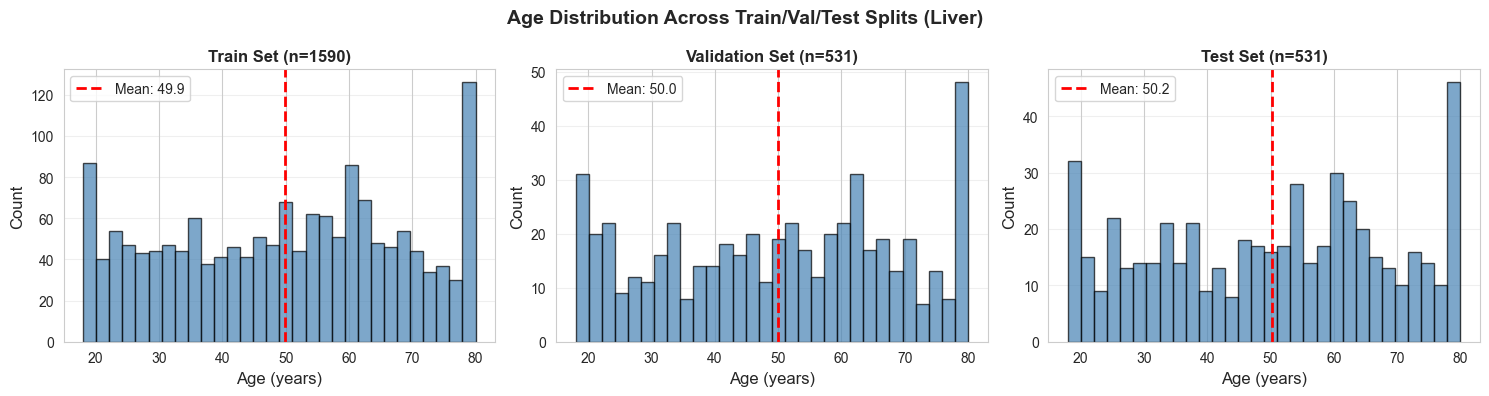


Note: Age distributions are similar across splits due to stratification.
This ensures fair model training and evaluation.


In [10]:
# Visualize split distributions for one organ
if organ_splits is not None and 'liver' in organ_splits:
    splits = organ_splits['liver']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, (split_name, split_data) in enumerate([('Train', splits['y_train']), 
                                                      ('Validation', splits['y_val']), 
                                                      ('Test', splits['y_test'])]):
        axes[idx].hist(split_data, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].axvline(split_data.mean(), color='red', linestyle='--', linewidth=2, 
                         label=f'Mean: {split_data.mean():.1f}')
        axes[idx].set_xlabel('Age (years)', fontsize=12)
        axes[idx].set_ylabel('Count', fontsize=12)
        axes[idx].set_title(f'{split_name} Set (n={len(split_data)})', fontsize=12, fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(axis='y', alpha=0.3)
    
    fig.suptitle('Age Distribution Across Train/Val/Test Splits (Liver)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nNote: Age distributions are similar across splits due to stratification.")
    print("This ensures fair model training and evaluation.")

## 7. Feature Scaling

### Why Scale Features?

Biomarkers have vastly different scales:
- Blood pressure: 80-180 mmHg
- Creatinine: 0.5-2.0 mg/dL
- Cholesterol: 100-300 mg/dL

Without scaling, models may:
- Be dominated by large-scale features
- Converge slowly or poorly
- Have difficulty with regularization

### Scaling Method: StandardScaler

We use **z-score standardization**:
$$z = \frac{x - \mu}{\sigma}$$

This transforms each feature to:
- Mean = 0
- Standard deviation = 1

### Critical: Fit on Train, Transform All

To prevent **data leakage**:
1. Fit scaler on training data only
2. Apply same transformation to val/test
3. Never use val/test statistics in scaling

In [11]:
if organ_splits is not None:
    print("=" * 60)
    print("FEATURE SCALING (STANDARDIZATION)")
    print("=" * 60)
    
    # Store scaled data and scalers
    organ_splits_scaled = {}
    organ_scalers = {}
    
    for organ_name, splits in organ_splits.items():
        print(f"\n{organ_name.upper()}:")
        
        # Scale features
        X_train_scaled, X_val_scaled, X_test_scaled, scaler = features.scale_features(
            splits['X_train'],
            splits['X_val'],
            splits['X_test'],
            method='standard'
        )
        
        # Store scaled data
        organ_splits_scaled[organ_name] = {
            'X_train': X_train_scaled,
            'X_val': X_val_scaled,
            'X_test': X_test_scaled,
            'y_train': splits['y_train'],
            'y_val': splits['y_val'],
            'y_test': splits['y_test']
        }
        
        organ_scalers[organ_name] = scaler
        
        # Verify scaling
        print(f"  Verification (train set):")
        print(f"    Mean: {X_train_scaled.mean().mean():.6f} (should be ~0)")
        print(f"    Std:  {X_train_scaled.std().mean():.6f} (should be ~1)")
    
    print(f"\n✓ Feature scaling complete for {len(organ_splits_scaled)} organs")
    print(f"\nScaled datasets ready for model training.")
else:
    print("⚠ Cannot scale features - splits not available")
    organ_splits_scaled = None
    organ_scalers = None

FEATURE SCALING (STANDARDIZATION)

LIVER:
Features scaled using standard scaler
  Verification (train set):
    Mean: 0.000000 (should be ~0)
    Std:  1.000315 (should be ~1)

KIDNEY:
Features scaled using standard scaler
  Verification (train set):
    Mean: -0.000000 (should be ~0)
    Std:  1.000315 (should be ~1)

CARDIO_METABOLIC:
Features scaled using standard scaler
  Verification (train set):
    Mean: -0.000000 (should be ~0)
    Std:  1.000315 (should be ~1)

IMMUNE:
Features scaled using standard scaler
  Verification (train set):
    Mean: 0.000000 (should be ~0)
    Std:  1.000315 (should be ~1)

HEMATOLOGIC:
Features scaled using standard scaler
  Verification (train set):
    Mean: -0.000000 (should be ~0)
    Std:  1.000315 (should be ~1)

✓ Feature scaling complete for 5 organs

Scaled datasets ready for model training.


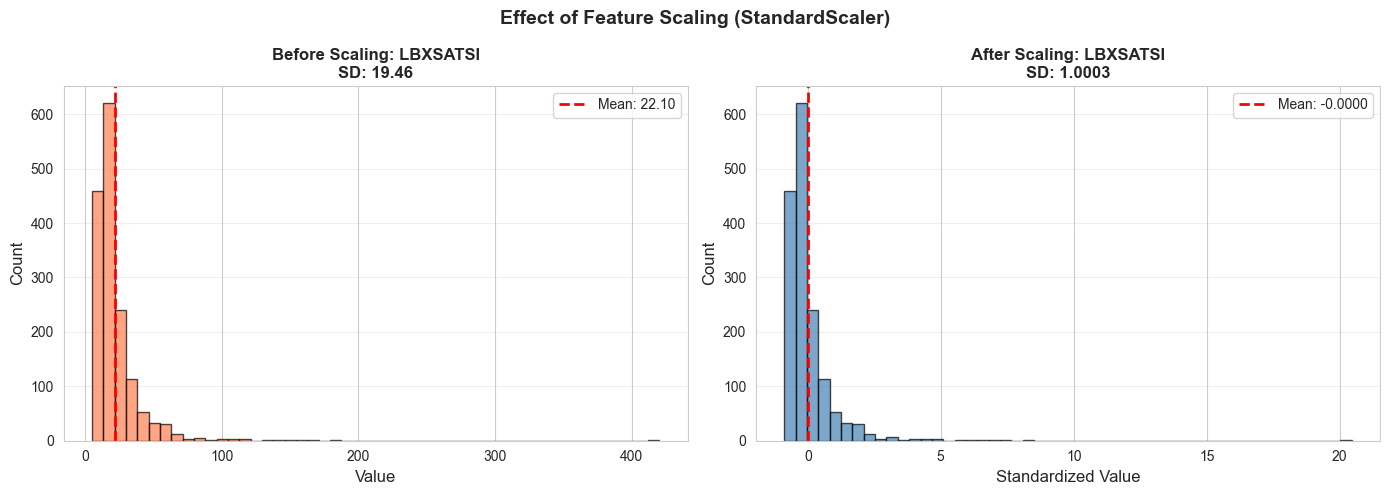


Scaling transforms features to:
  - Mean ≈ 0
  - Standard Deviation ≈ 1
  - Shape of distribution is preserved


In [12]:
# Compare distributions before and after scaling
if organ_splits is not None and organ_splits_scaled is not None and 'liver' in organ_splits:
    # Select one feature to demonstrate
    feature_col = organ_splits['liver']['X_train'].columns[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Before scaling
    data_before = organ_splits['liver']['X_train'][feature_col]
    axes[0].hist(data_before, bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[0].axvline(data_before.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {data_before.mean():.2f}')
    axes[0].set_xlabel('Value', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title(f'Before Scaling: {feature_col}\nSD: {data_before.std():.2f}', 
                     fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # After scaling
    data_after = organ_splits_scaled['liver']['X_train'][feature_col]
    axes[1].hist(data_after, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1].axvline(data_after.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {data_after.mean():.4f}')
    axes[1].set_xlabel('Standardized Value', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title(f'After Scaling: {feature_col}\nSD: {data_after.std():.4f}', 
                     fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    fig.suptitle('Effect of Feature Scaling (StandardScaler)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nScaling transforms features to:")
    print("  - Mean ≈ 0")
    print("  - Standard Deviation ≈ 1")
    print("  - Shape of distribution is preserved")

## 8. Save Processed Datasets

### Output Organization

We save:
1. **Splits**: Train/val/test for each organ
2. **Scalers**: To transform new data consistently
3. **Metadata**: Sample sizes, feature names

### File Format

Using **Parquet** for efficiency and type preservation.

In [13]:
# Save processed datasets
if organ_splits_scaled is not None:
    import joblib
    
    # Create output directories
    processed_dir = project_root / "data" / "processed"
    processed_dir.mkdir(parents=True, exist_ok=True)
    
    scalers_dir = project_root / "models" / "scalers"
    scalers_dir.mkdir(parents=True, exist_ok=True)
    
    print("Saving processed datasets...\n")
    
    for organ_name, splits in organ_splits_scaled.items():
        organ_dir = processed_dir / organ_name
        organ_dir.mkdir(parents=True, exist_ok=True)
        
        # Save each split
        for split_name in ['train', 'val', 'test']:
            X_data = splits[f'X_{split_name}']
            y_data = splits[f'y_{split_name}']
            
            # Combine X and y for easier loading
            combined = X_data.copy()
            combined['AGE'] = y_data
            
            output_path = organ_dir / f"{split_name}.parquet"
            combined.to_parquet(output_path, index=False)
        
        # Save scaler
        scaler_path = scalers_dir / f"{organ_name}_scaler.pkl"
        joblib.dump(organ_scalers[organ_name], scaler_path)
        
        print(f"✓ {organ_name}: Saved train/val/test splits and scaler")
    
    print(f"\n✓ All processed data saved to: {processed_dir}")
    print(f"✓ All scalers saved to: {scalers_dir}")
    
    # Save metadata
    metadata = {}
    for organ_name, splits in organ_splits_scaled.items():
        metadata[organ_name] = {
            'n_train': len(splits['X_train']),
            'n_val': len(splits['X_val']),
            'n_test': len(splits['X_test']),
            'n_features': splits['X_train'].shape[1],
            'features': splits['X_train'].columns.tolist()
        }
    
    metadata_path = processed_dir / "metadata.json"
    import json
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✓ Metadata saved to: {metadata_path}")
else:
    print("⚠ No processed data to save")

Saving processed datasets...

✓ liver: Saved train/val/test splits and scaler
✓ kidney: Saved train/val/test splits and scaler
✓ cardio_metabolic: Saved train/val/test splits and scaler
✓ immune: Saved train/val/test splits and scaler
✓ hematologic: Saved train/val/test splits and scaler

✓ All processed data saved to: C:\Users\bastien\Documents\TAF\Hackathon\Vitalist\data\processed
✓ All scalers saved to: C:\Users\bastien\Documents\TAF\Hackathon\Vitalist\models\scalers
✓ Metadata saved to: C:\Users\bastien\Documents\TAF\Hackathon\Vitalist\data\processed\metadata.json


## 9. Feature Importance Preview

Before training models, let's examine which features show strongest linear relationships with age.

Top 20 Features Most Correlated with Age:



,Organ,Feature,Correlation
0,cardio_metabolic,BPXSY1,0.472549
1,liver,LBXSBU,0.379212
2,kidney,LBXSBU,0.379212
3,cardio_metabolic,LBXGH,0.331038
4,kidney,URXUCR,-0.231867
5,cardio_metabolic,LBXGLU,0.229677
6,kidney,BUN_Cr_Ratio,0.225371
7,hematologic,LBXRBCSI,-0.203858
8,hematologic,LBXMCVSI,0.199266
9,kidney,LBXSCR,0.194041


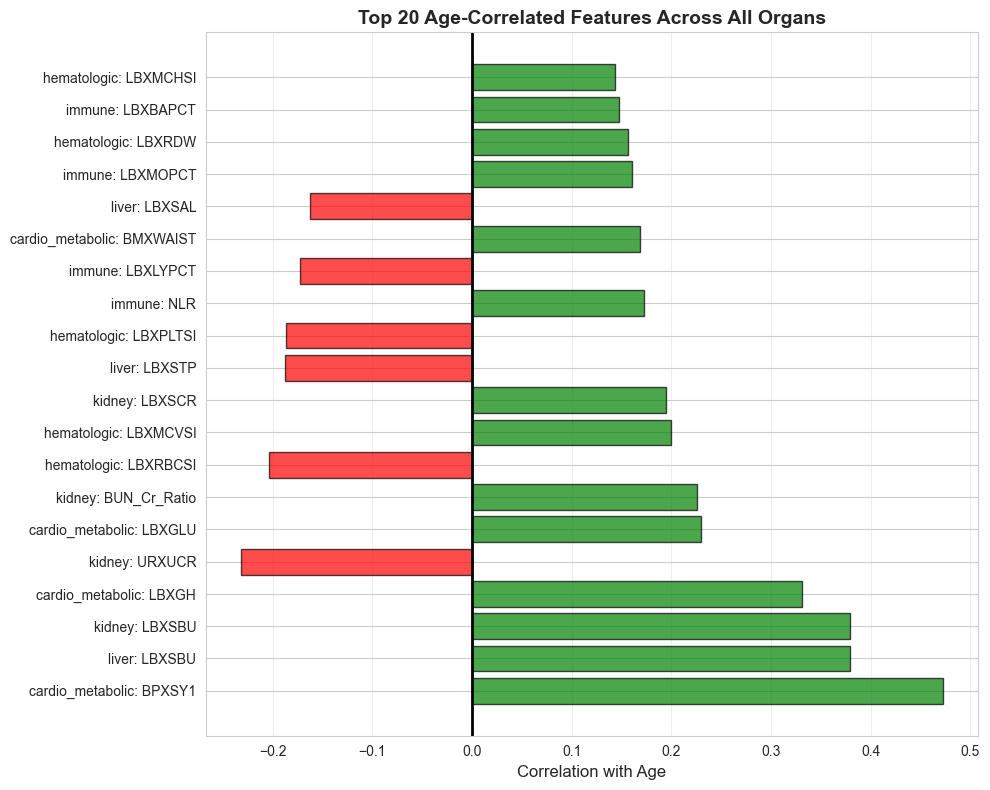


Interpretation:
  - These features show strongest linear relationships with age
  - Likely to be important predictors in organ clocks
  - Non-linear models may capture additional complexity


In [14]:
# Calculate feature correlations with age for all organs
if organ_splits_scaled is not None:
    correlation_summary = []
    
    for organ_name, splits in organ_splits_scaled.items():
        X_train = splits['X_train']
        y_train = splits['y_train']
        
        for col in X_train.columns:
            corr = X_train[col].corr(y_train)
            correlation_summary.append({
                'Organ': organ_name,
                'Feature': col,
                'Correlation': corr,
                'Abs_Correlation': abs(corr)
            })
    
    corr_df = pd.DataFrame(correlation_summary)
    
    # Top 20 features by absolute correlation
    top_features = corr_df.nlargest(20, 'Abs_Correlation')
    
    print("Top 20 Features Most Correlated with Age:\n")
    display(top_features[['Organ', 'Feature', 'Correlation']].reset_index(drop=True))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['green' if x > 0 else 'red' for x in top_features['Correlation']]
    labels = [f"{row['Organ']}: {row['Feature']}" for _, row in top_features.iterrows()]
    
    ax.barh(labels, top_features['Correlation'], color=colors, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='black', linewidth=2)
    ax.set_xlabel('Correlation with Age', fontsize=12)
    ax.set_title('Top 20 Age-Correlated Features Across All Organs', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("  - These features show strongest linear relationships with age")
    print("  - Likely to be important predictors in organ clocks")
    print("  - Non-linear models may capture additional complexity")

## 10. Summary and Next Steps

### What We Accomplished

✓ Loaded cleaned NHANES data
✓ Built organ-specific feature matrices (biomarkers + covariates)
✓ Created stratified train/validation/test splits (60/20/20)
✓ Applied feature scaling (standardization)
✓ Visualized feature distributions and correlations
✓ Saved processed datasets for model training

### Data Ready for Modeling

For each organ system:
- **Training set**: For model fitting
- **Validation set**: For hyperparameter tuning
- **Test set**: For final evaluation
- **Scaler**: For consistent transformation

### Feature Engineering Highlights

- Sample sizes vary by organ (due to missing data patterns)
- Features are standardized (mean=0, std=1)
- Age distributions are balanced across splits
- Global covariates included in all models

### Next Notebook: Model Training

In `03_train_organ_clocks.ipynb`, we will:
1. Train linear and non-linear models for each organ
2. Evaluate performance on train/val/test sets
3. Analyze feature importance
4. Compare model architectures
5. Save trained organ clocks

---

**TDD Note**: All feature engineering functions are tested in `tests/test_features.py`